# demo_gammachirp_notebook
This notebook demonstrates:
- Frequency Response
- Center Frequency vs. ERB Width
- Filter Level Dependency
- Input/Output Function of the Gammachirp Finterbank with the GammachirPy packege.

Note:
- The original article is [HERE](https://doi.org/10.20697/jasj.66.10_506) (Irino, 2010, in Japanese)
- The original MATLAB code is [HERE](https://researchmap.jp/irino/資料公開/) (Irino, 2010-2021, in Japanese)

References:
- Irino,T. and Patterson,R.D.: JASA, Vol.101, pp.412-419, 1997.
- Irino,T. and Patterson,R.D.: JASA, Vol.109, pp.2008-2022, 2001.
- Patterson,R.D., Unoki,M. and Irino,T.: JASA, Vol.114, pp.1529-1542, 2003. 
- Irino,T. and Patterson,R.D.: IEEE Trans.ASLP, Vol.14, pp.2222-2232, 2006.

### Setup

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

import utils as utils
import gcfb_v211 as gcfb
import gammachirp as gc

In [2]:
# Parameter values from Patterson+ (2003)
n = 4       
b1 = 1.81   
c1 = -2.96  
b2 = 2.17   
c2 = 2.20   
frat0 = 0.466
frat1 = 0.0109

n_rsl = 2**12
fs = 44100
ps = 50 # input level

frat = frat0 + frat1*ps

### Frequency Response

In [3]:
# peak frequency of each filter channel
fp_list = np.array([250, 500, 1000, 2000, 4000, 8000])
fp_xtick = np.array([100, 250, 500, 1000, 2000, 4000, 8000, 16000])
erb_n_xtick, _ = utils.freq2erb(fp_xtick)

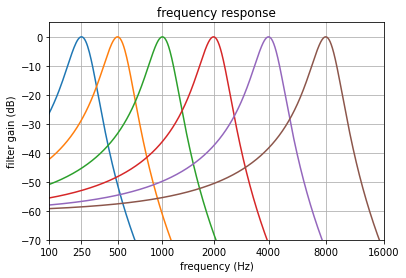

In [4]:
fig, ax = plt.subplots()

for fp in fp_list:
    # calculate frequency renponse
    fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp)
    cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
    cgc_frsp = cgc_resp.cgc_frsp
    
    # convert level and frequency scale to plot
    cgc_frsp_db = 20 * np.log10(cgc_frsp/np.max(cgc_frsp))
    freq = np.array(cgc_resp.freq)
    erb_num, _ = utils.freq2erb(freq)

    # plot frequency renponse of each filter channel
    plt.plot(erb_num[0, :], cgc_frsp_db[0, :])
    ax.set_xlim([erb_n_xtick[0], erb_n_xtick[-1]])
    ax.set_ylim([-70, 5])
    ax.set_xticks(erb_n_xtick)
    ax.set_xticklabels(fp_xtick)
    ax.set_xlabel("frequency (Hz)")
    ax.set_ylabel("filter gain (dB)")
    plt.title("frequency response")

plt.grid()

plt.show()

### Center Frequency vs. ERB Width

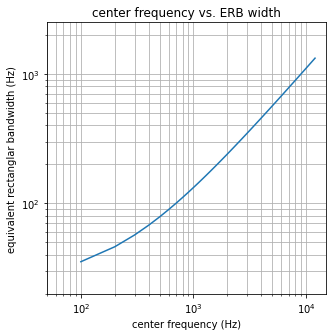

In [5]:
# convert linear frequency to ERB_N scale
freq = np.arange(100, 12000+1, 100)
_, erb_n = utils.freq2erb(freq)

# plot in log scale
fig, ax = plt.subplots(figsize=(5,5))
plt.loglog(freq, erb_n)
ax.set_xlim([50, 15000])
ax.set_ylim([20, 2500])
plt.grid(which='both')
ax.set_xlabel("center frequency (Hz)")
ax.set_ylabel("equivalent rectanglar bandwidth (Hz)")
plt.title("center frequency vs. ERB width")

plt.show()

### Filter Level Dependency

In [6]:
marker = ['o','x','d','*','^','p','s']
cmap = plt.get_cmap("tab10")

fp = 2000 # peak frequency
ps_list = [30, 40, 50, 60, 70, 80, 90] # input level (dB)

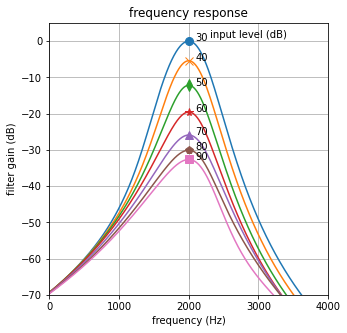

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

cgc_frs_db_max = np.array([])
for cnt, ps in enumerate(ps_list):
    # input level changes dcGC parameters
    frat = frat0 + frat1*ps

    # calculate frequency renponse
    fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp) 
    cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
    cgc_frsp = cgc_resp.cgc_frsp

    # reference: peak level at the smallest input level (30 dB)
    if cnt == 0:
        cgc_frsp_ref = np.max(cgc_frsp)

    # calculate relative frequency response 
    cgc_frsp_db = 20 * np.log10(cgc_frsp/np.max(cgc_frsp_ref))
    freq = np.array(cgc_resp.freq)
    cgc_frs_db_max = np.append(cgc_frs_db_max, np.max(cgc_frsp_db))

    # plot
    plt.plot(freq[0, :], cgc_frsp_db[0, :], color=cmap(cnt))
    plt.plot(fp, cgc_frs_db_max[cnt], marker[cnt], color=cmap(cnt), markersize=8)
    ax.set_xlim([0, 4000])
    ax.set_ylim([-70, 5])
    ax.set_xticks([0, 1000, 2000, 3000, 4000])
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('filter gain (dB)')
    plt.grid()
    plt.text(fp*1.05, cgc_frs_db_max[cnt], f"{ps}")

plt.text(fp*1.15, 1.0, 'input level (dB)')
plt.title('frequency response')

plt.show()

### Input/Output Function

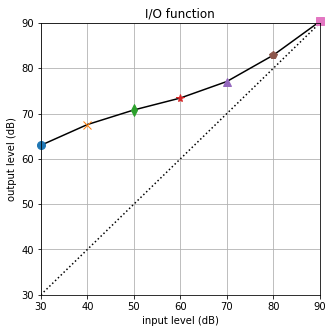

In [8]:
fig, ax = plt.subplots(figsize=(5,5))

# adjust output level to 90 dB when the input level is 90 dB
output_level = cgc_frs_db_max + ps_list + 33

# plot I/O function with a "linear" I/O function
plt.plot(ps_list, output_level, 'k', ps_list, ps_list, ':k')

# plot markers at each corrspond I/O level 
for cnt in range(len(output_level)):
    plt.plot(ps_list[cnt], output_level[cnt], marker[cnt], \
        color=cmap(cnt), clip_on = False, markersize=8)

ax.set_xlim([30, 90])
ax.set_ylim([30, 90])
ax.set_xlabel("input level (dB)")
ax.set_ylabel("output level (dB)")
plt.title("I/O function")
plt.grid()

plt.show()

### Impulse Response of Gammatone & Gammachirp 

In [9]:
# auditory filter parameters
fp = 2000
fs = 44100
n = 4
b = 1.019 # default gammatone
cgt = 0
cgc = -3

# gammatone
gt_ir, len_gt, _, _ = gc.gammachirp(fp, fs, n, b, cgt)
gm_env, _, _, _ = gc.gammachirp(fp, fs, n, b, cgt, 0, 'env')

# gammachirp
gc_ir, len_gc, _, _ = gc.gammachirp(fp, fs, n, b, cgc)

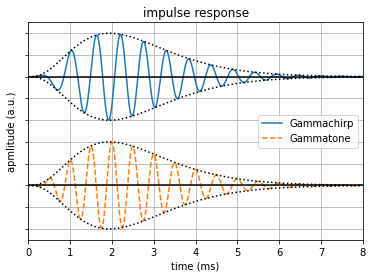

In [10]:
# plot
tpl = 8
npl = np.arange(tpl*fs/1000).astype(int)
tms = npl/fs*1000
bz = 2.5
gme = np.array([[1], [-1]]) * gm_env[0, [npl]]

fig, ax = plt.subplots()
plt.plot(tms, gc_ir[0, [npl]][0, :]+bz, label='Gammachirp')
plt.plot(tms, gt_ir[0, [npl]][0, :], '--', label='Gammatone')

plt.plot(tms, gme[0, :], ':k', tms, gme[1,:], ':k', \
         tms, gme[0, :]+bz,':k', tms, gme[1,:]+bz, ':k', \
         [0, tpl], [0, 0], 'k', \
         [0, tpl], [bz, bz], 'k')

ax.set_xlim([0, tpl])
ax.set_yticks(np.arange(-1, bz+1.5, 0.5))
ax.set_ylim([0-1.25, bz+1.25])
ax.set_yticklabels('')
ax.set_xlabel('time (ms)')
ax.set_ylabel('apmlitude (a.u.)')
ax.legend(loc='center right')
plt.title('impulse response')
plt.grid()

plt.show()

### Frequency Response of Gammatone & Gammachirp 

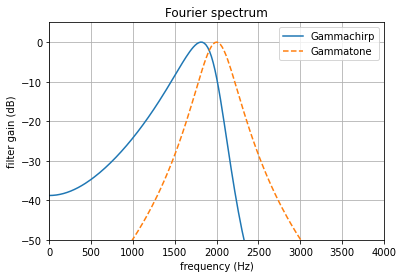

In [11]:
# parameter settings
fs = 44100
n_frsl = 1024

# frequency renponse of each auditory filter
# gammatone
freq, frsp_gt = signal.freqz(gt_ir[0, :], 1, n_frsl, fs=fs)
gt_db = 20 * np.log10(np.abs(frsp_gt))
gt_db = gt_db  - np.max(gt_db)

# gammachirp
freq, frsp_gc = signal.freqz(gc_ir[0, :], 1, n_frsl, fs=fs)
gc_db = 20 * np.log10(np.abs(frsp_gc))
gc_db = gc_db  - np.max(gc_db)

# plot
fig, ax = plt.subplots()
plt.plot(freq, gc_db, label='Gammachirp')
plt.plot(freq, gt_db, '--', label='Gammatone')
ax.set_xlim([0, fp*2])
ax.set_ylim([-50, 5])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('filter gain (dB)')
plt.title('Fourier spectrum')
plt.grid()
plt.legend()

plt.show()